<a href="https://colab.research.google.com/github/itsvismay/Trying-Differentiable-Physics-in-Jax/blob/main/5_Jax_Matching_Motion_On_Bigger_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **5. Motion Matching on Larger Systems**
## Intro
Previously, I matched the motion, start pose and stiffness of a super simple mass spring system on a similar system. In this doc, I will do the same for a larger mass-spring system. The steps are:


1.   Setup the target mass spring system and initial parameters
2.   Write the spring energy, and gradients
3.   Simulate the target system for 200 timesteps and store the positions at each step into a list called *spring_target_states*
4.   Create the second mass-spring system and initialize with a different start pose and parameters than the target system
5.   Create a *physics_loss* function that acts as our optimization loss by return the difference between positions of the two systems at each timestep
6.   Calculate physics loss gradient and optimize using simple gradient descent



Import meshzoo. This creates simple meshes for me.

In [2]:
!pip install meshzoo
%matplotlib inline
import jax.numpy as jp
from jax import grad, jit, vmap, jacfwd, jacrev
from jax.lax import scan
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib import animation, rc
from IPython.display import HTML
from functools import partial
import meshzoo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 5.4 MB/s 
     |████████████████████████████████| 54 kB 2.6 MB/s 
     |████████████████████████████████| 99 kB 8.9 MB/s 
     |████████████████████████████████| 4.0 MB 50.1 MB/s 
     |████████████████████████████████| 856 kB 65.6 MB/s 
     |████████████████████████████████| 237 kB 36.4 MB/s 
     |████████████████████████████████| 51 kB 7.1 MB/s 


**Create** a target mesh and a second mesh object. Change the start state of the second mesh later on.

In [3]:
# rest nodes x,y,z//x,y,z
X0, E = meshzoo.rectangle_tri(
    jp.linspace(0.0, 3.0, 3),
    jp.linspace(5.0, 8.0, 3),
    variant="zigzag",  # or "up", "down", "center"
)
mesh_obj = {"verts": X0, "edges": E}

# rest nodes x,y,z//x,y,z
X0_2 = jp.array(X0.copy())
X0_2 = X0_2.at[jp.array([0,1,2,3,4,5]),1].add(-2)
X0_2 = X0_2.at[jp.array([0,1,2]),1].add(-2)
mesh_obj2 = {"verts": X0_2, "edges": E}

Major updates to the animation code using triplot for plotting this complex mesh. Plot the two meshes, target mesh and the other mesh for reference.

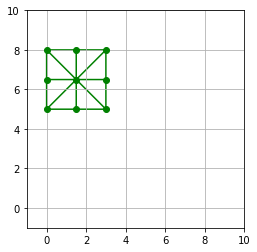

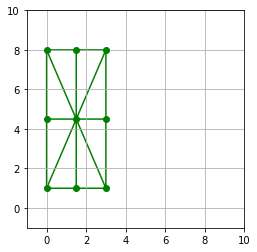

In [4]:
# Plotting tools
def plot(state,  E):
    fig = plt.figure()
    ax = fig.add_subplot(autoscale_on=False, xlim=(-1, 10), ylim=(-1, 10))
    # NOTE: there is no .set_data() for 3 dim data...
    nodes = state#-1 value is inferred
    triang = tri.Triangulation(nodes[:,0], nodes[:,1], triangles=E)
    ax.triplot(triang, 'go-')
    ax.set_aspect('equal')
    ax.grid()
    plt.show()
    
def animate(states1, E):
    fig = plt.figure()
    xlim=(-5, 10)
    ylim=(-10, 10)
    ax = fig.add_subplot(autoscale_on=False, xlim=xlim, ylim=ylim)
    springs1 = ax.triplot(states1[0,:,0], states1[0,:,1], E, 'go-')
    def update(i):
        # # NOTE: there is no .set_data() for 3 dim data...
        ax.cla()
        ax.set(xlim=xlim, ylim=ylim)
        springs1 = ax.triplot(states1[i,:,0], states1[i,:,1], E, 'go-')
        return fig
    anim = animation.FuncAnimation(fig, update, states1.shape[0], interval=20)
    plt.close()
    return anim

def animate_both(states1, states2, E):
    fig = plt.figure()
    xlim=(-5, 10)
    ylim=(-20, 20)
    ax = fig.add_subplot(autoscale_on=False, xlim=xlim, ylim=ylim)
    springs1 = ax.triplot(states1[0,:,0], states1[0,:,1], E, 'go-')
    springs2 = ax.triplot(states2[0,:,0], states2[0,:,1], E, 'bo-')
    def update(i):
        # # NOTE: there is no .set_data() for 3 dim data...
        ax.cla()
        ax.set(xlim=xlim, ylim=ylim)
        springs1 = ax.triplot(states1[i,:,0], states1[i,:,1], E, 'go-')
        springs2 = ax.triplot(states2[i,:,0], states2[i,:,1], E, 'bo-')
        return fig
    anim = animation.FuncAnimation(fig, update, states1.shape[0], interval=20)
    plt.close()
    return anim
plot(X0, E)
plot(X0_2, E)


**Create** spring systems with initial paprameters

In [5]:
class WorldPhysicsState:
    g : jp.ndarray = jp.array([[0.0,-9.8,0.0]])
    dt: float = 0.1
        
class SpringPhysicsState:
    L0: jp.ndarray
    X0: jp.ndarray
    E: jp.ndarray
    invM: jp.ndarray
    pin: jp.ndarray
    #physics variables
    x: jp.ndarray
    k: jp.ndarray
    v: jp.ndarray
    states: list

def initWorld():
    return WorldPhysicsState()
    
def initSpring(mesh_obj):
    springs = SpringPhysicsState()
    # Physics constants
    springs.X0  = mesh_obj["verts"]
    springs.E = mesh_obj["edges"]
    springs.L0 = jp.linalg.norm(springs.X0[springs.E[:,1]] - springs.X0[springs.E[:,0]], axis=1)
    springs.M = 0.1*jp.ones(springs.X0.shape[0]) # mass per vertex

    # Pinned verts indices: TODO: better way to do this (not by hand)
    springs.pin = jp.array([6,7,8])

    # Physics variables
    springs.x = springs.X0.copy()
    springs.k = 1*jp.ones(springs.E.shape[0]) # stiffness per spring (element), TODO: turn into variable
    springs.v = 0*springs.x
    
    return springs

world = initWorld()
spring_target = initSpring(mesh_obj)

**Spring system energy functions** for each spring element as well as gravity potential energy at the verts. For now, each node has a fixed mass. **Gradients** functions of the energy is also calculated using jax.grad. Additionally an explicit (verlet) **simulation** function records the historical position of the spring at each timestep.

In [6]:

def mesh_energy(X, K, X0, Ele, M):
  def spring_energy(X,K, X0):
    return 0.5*K*(jp.linalg.norm(X[0,:] - X[1,:])-jp.linalg.norm(X0[0,:] - X0[1,:]))*(jp.linalg.norm(X[0,:] - X[1,:])-jp.linalg.norm(X0[0,:] - X0[1,:]))

  def ele_energy(X, K, X0):
    return spring_energy(X,K,X0)

  def vert_energy(X, M):
      return M*X[1]*9.81
  #Run mesh energy
  s = vmap(ele_energy)(X[Ele,:], K, X0[Ele,:])
  v = vmap(vert_energy)(X, M)
  return jp.sum(s) + jp.sum(v)


grad_fcn = jit(grad(mesh_energy))

def simulate(optVar, spring, grad_fcn, dt, sim_steps):
    def step(carry, accum, K, X0, E, M, pin, dt):
      x,v = carry
      forces = -1*grad_fcn(x, K, X0, E, M)
      forces = forces.at[pin].set(0)
      v_new = v + dt*(forces/M[:,None])
      x_new = x + v_new * dt - 0.1*v
      carry = (x_new, v_new)
      accum = x_new
      return (carry, accum)

    pstep = partial(step, 
                    K=optVar[0], 
                    X0=optVar[1], 
                    E= spring.E, 
                    M = spring.M, 
                    pin=spring.pin, 
                    dt = dt)

    carry = (optVar[1], spring.v)
    outputs = []
    carry, outputs = scan(pstep, 
                          carry, 
                          xs=None, 
                          length=sim_steps)
    
    return outputs

**Create** a New Spring (Green) and simulate both the target(blue) and new springs. Animate both for 200 steps and notice the differences.

In [7]:
spring_target_states = simulate((spring_target.k, spring_target.X0), spring_target, grad_fcn, world.dt, 200)
# HTML(animate(spring_target_states, spring_target.E).to_html5_video())
# create new spring
spring_current = initSpring(mesh_obj2)
# change up its stiffness
spring_current.k = 0.2*spring_current.k

initial_states = simulate((spring_current.k, spring_current.X0), spring_current, grad_fcn, world.dt, 200)
HTML(animate_both(initial_states, spring_target_states, spring_target.E).to_html5_video())

**Create the physics loss** function and its gradient which takes the norm between the target spring and the spring being optimized.

In [11]:
@jit
def simulation_match_loss(opt_var, target_states):
    states = simulate(opt_var, spring_current, grad_fcn, world.dt, 200)
    #loss = the difference at each timestep between target states and current states
    loss = jp.linalg.norm(target_states - states)
    return loss

grad_simulation_match_loss = grad(simulation_match_loss, argnums=0)

**Optimize over the physics simulation loss** with gradient descent. Todo: use jax.grad_with_value instead of jax.grad

In [12]:
ov_k, ov_X0 = spring_current.k,spring_current.X0
optVars = (ov_k, ov_X0)
#Crappy gradient descent with fixed step size
for _ in range(200):
    dk,dX0 = grad_simulation_match_loss(optVars, spring_target_states)
    dX0 = dX0.at[spring_current.pin].set(0)
    ov_k -= dk*0.01
    ov_X0 -= dX0*0.01
    optVars = ov_k, ov_X0
    print("loss: "+str(simulation_match_loss(optVars, spring_target_states)))


loss: 124.13845
loss: 93.26866
loss: 80.63957
loss: 71.72238
loss: 64.99509
loss: 59.79598
loss: 55.73459
loss: 52.54118
loss: 50.01302
loss: 47.99308
loss: 46.359936
loss: 45.02075
loss: 43.90534
loss: 42.96098
loss: 42.148132
loss: 41.43706
loss: 40.80528
loss: 40.23566
loss: 39.715042
loss: 39.233303
loss: 38.78247
loss: 38.356358
loss: 37.95001
loss: 37.559536
loss: 37.181786
loss: 36.814262
loss: 36.454937
loss: 36.102177
loss: 35.75467
loss: 35.411343
loss: 35.071377
loss: 34.734085
loss: 34.39893
loss: 34.0655
loss: 33.733463
loss: 33.40259
loss: 33.07266
loss: 32.74354
loss: 32.415127
loss: 32.087315
loss: 31.760027
loss: 31.4332
loss: 31.106777
loss: 30.780685
loss: 30.454874
loss: 30.129297
loss: 29.803888
loss: 29.478613
loss: 29.153404
loss: 28.828232
loss: 28.50303
loss: 28.177761
loss: 27.852383
loss: 27.526823
loss: 27.201044
loss: 26.874987
loss: 26.548576
loss: 26.221762
loss: 25.89446
loss: 25.566608
loss: 25.238104
loss: 24.908869
loss: 24.578798
loss: 24.247797
loss

**Animate** the final optimized state of the spring system and overlay with the target simulation

In [13]:
states = simulate(optVars, spring_current, grad_fcn, world.dt, 100)
anim2 = animate_both(states, spring_target_states, spring_target.E)
HTML(anim2.to_html5_video())

Check out the values of the optimization variables.

In [14]:
states = simulate(optVars, spring_current, grad_fcn, world.dt, 10)
print(optVars)


(DeviceArray([0.9631523 , 1.1284926 , 1.1065242 , 1.2472187 , 0.8357067 ,
             0.33415696, 1.2151097 , 0.9100202 ], dtype=float32), DeviceArray([[0.06989688, 4.9270487 ],
             [1.3458464 , 5.0103164 ],
             [3.0655    , 5.013236  ],
             [0.02527694, 6.510644  ],
             [1.3350673 , 6.4121537 ],
             [3.0139718 , 6.4417615 ],
             [0.        , 8.        ],
             [1.5       , 8.        ],
             [3.        , 8.        ]], dtype=float32))


## Next Steps


1.   Baraf Witkin cloth energy
2.   Differentiate through an implicit simulation
3.   Try to use other loss functions. Maybe look at forces/velocity rather than just position
4.   Use ADAM or something with a LS step for the optimization. 

